# Various phase generating libraries

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
import proper  
import astropy.units as u
from skimage.transform import resize
import warnings

In [2]:
def resize_img(img, new_size, preserve_range=True, mode='reflect', anti_aliasing=True):
    ''' Resize an image. Handles even and odd sizes.
    '''
    requirement = "new_size must be an int or a tuple/list of size 2."
    assert type(new_size) in [int, tuple, list], requirement
    if type(new_size) is int:
        new_size = (new_size, new_size)
    else:
        assert len(new_size) == 2, requirement
    assert  img.ndim in [2, 3], 'image must be a frame (2D) or a cube (3D)'
    if img.ndim == 3:
        new_size = (len(img), *new_size)
    if new_size != img.shape:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore") # when anti_aliasing=False, and NANs
            img = np.float32(resize(np.float32(img), new_size, mode=mode, 
                preserve_range=preserve_range, anti_aliasing=anti_aliasing))
    return img



def pad_img(img, padded_size, pad_value=0):
    ''' Pad an img with a value (default is zero). Handles even and odd sizes.
    '''
    requirement = "padded_size must be an int or a tuple/list of size 2."
    assert type(padded_size) in [int, tuple, list], requirement
    if type(padded_size) is int:
        (x1, y1) = (padded_size, padded_size)
    else:
        assert len(padded_size) == 2, requirement
        (x1, y1) = padded_size
    (x2, y2) = img.shape
    # determine padding region
    assert not (x1<x2 or y1<y2), "padding region can't be smaller than image size."
    dx = int((x1 - x2)/2)
    dy = int((y1 - y2)/2)
    padx = (dx, dx) if (x1-x2)%2==0 else (dx+1, dx)
    pady = (dy, dy) if (y1-y2)%2==0 else (dy+1, dy)
    # pad image
    img = np.pad(img, [padx, pady], mode='constant', constant_values=pad_value)
    return img

#### Use power spectral density, $\phi$ of Kolmogorov turbulence

### $\phi(k) = 0.023 r_0^{-5/3}k^{-11/3}$


Generate complex independent, Gaussian, random numbers
with zero mean and unit variance.

Multiply by the square root of the PSD

Set PSD=0 at κ=0

Take the discrete Fourier transform.

The real component is a Kolmogorov phase screen.


In [3]:
def kolmo_psd(D, sz, r0):
    ''' A simple kolmogrov phase screen generator
    - sz is grid size
    - D is the telescope diameter
    - r0 is fried parameter
    '''
    dxy = D/sz
    df = 1/(sz*dxy)

    xf = np.arange(-sz/2,sz/2) * df
    xx, yy = np.meshgrid(xf,xf)
    k = np.sqrt(xx**2 + yy**2)
    k[sz//2, sz//2] = 1 # to avoid division by zero
    PSD = 0.023*r0**(-5/3)*k**(-11/3)
    PSD[sz//2, sz//2] = 0 # remove piston
    
    c = np.random.randn(sz,sz) +1j * np.random.randn(sz,sz)
    phs_screen = np.sqrt(PSD)*c
    
    kolmo = (np.fft.ifft2(np.fft.fftshift(phs_screen*sz*sz))).real
    return kolmo

In [4]:
from numpy import fft
import random

def ift2(G, delta_f ,FFT=None):
    """
    Wrapper for inverse fourier transform
    Parameters:
        G: data to transform
        delta_f: pixel seperation
        FFT (FFT object, optional): An accelerated FFT object
    """
        
    N = G.shape[0]

    if FFT:
        g = numpy.fft.fftshift( FFT( numpy.fft.fftshift(G) ) ) * (N * delta_f)**2
    else:
        g = fft.ifftshift( fft.ifft2( fft.fftshift(G) ) ) * (N * delta_f)**2

    return g

def ft_phase_screen(r0, N, delta, L0, l0, FFT=None, seed=None):
    '''
    Creates a random phase screen with Von Karmen statistics.
    (Schmidt 2010)
    
    Parameters:
        r0 (float): r0 parameter of scrn in metres
        N (int): Size of phase scrn in pxls
        delta (float): size in Metres of each pxl
        L0 (float): Size of outer-scale in metres
        l0 (float): inner scale in metres
    Returns:
        ndarray: numpy array representing phase screen
    '''
    delta = float(delta)
    r0 = float(r0)
    L0 = float(L0)
    l0 = float(l0)

    R = random.SystemRandom(time.time())
    if seed is None:
        seed = int(R.random()*100000)
    np.random.seed(seed)

    del_f = 1./(N*delta)

    fx = np.arange(-N/2.,N/2.) * del_f

    (fx,fy) = np.meshgrid(fx,fx)
    f = np.sqrt(fx**2 + fy**2)

    fm = 5.92/l0/(2*np.pi)
    f0 = 1./L0

    PSD_phi  = (0.023*r0**(-5./3.) * np.exp(-1*((f/fm)**2)) /
                ( ( (f**2) + (f0**2) )**(11./6) ) )

    PSD_phi[int(N/2), int(N/2)] = 0

    cn = ( (np.random.normal(size=(N,N)) + 1j* np.random.normal(size=(N,N)) )
                * np.sqrt(PSD_phi)*del_f )

    phs = ift2(cn,1, FFT).real


    return phs

In [5]:
D = 3
r0 = 0.15
N = 512 
delta = D/N
L0, l0 = 100, 0.10
wavelength1 = 550e-9


screen1 = kolmo_psd(D, 512, .15)
screen = ft_phase_screen(r0, N, delta, L0, l0)

screen *= wavelength1/(2*np.pi)
screen /= 1e-6

print(np.min(screen1), np.max(screen1))
print(np.min(screen), np.max(screen))



-35.69633156347904 50.24416000966434
-1.1693408994145167 1.212590585443007


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HP\AppData\Local\Temp\ipykernel_4100\1747847332.py:6: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label("$\mu$m", size=18)


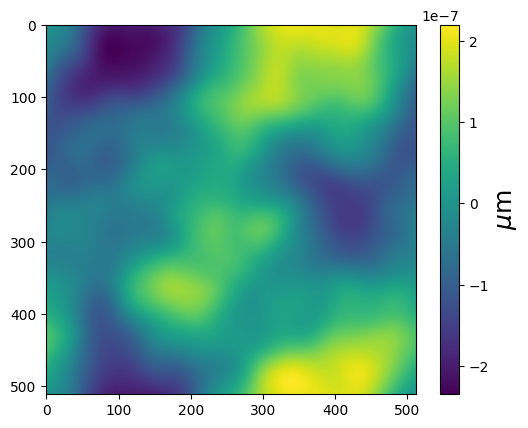

In [17]:
%matplotlib inline
plt.figure()
plt.imshow(screen)

cbar = plt.colorbar()
cbar.set_label("$\mu$m", size=18)
#cbar.set_clim(-1,1)
#plt.colorbar()
plt.show()

In [7]:
def rms(phase_screen):
    return np.sqrt(np.mean(phase_screen**2))

Dia = 0.6

r0 = 0.15
sz = 512

L0, l0 = 100, 0.10
wavelength = 1.6e-6
f_lens = 24 * Dia

scale = 1 # 1.22
tel_res = scale*wavelength/Dia*206265*1e3  # in milli-arcsec 

pscale = int(tel_res/10)  # in mas 


beam_ratio = (pscale*u.mas/(wavelength/Dia)).to('rad').value

delta = Dia/sz#/beam_ratio
screen = ft_phase_screen(r0, sz, delta, L0, l0)
screen *=wavelength1/(2*np.pi) 
fphase = screen*wavelength/wavelength1


delta = Dia/sz/beam_ratio
screen1 = ft_phase_screen(r0, sz, delta, L0, l0)
#screen1 *= wavelength1/(2*np.pi) 

#fphase1 = screen1*wavelength/wavelength1


print(np.std(screen), rms(screen))
#print(np.std(screen), np.std(screen1))


nn = int(beam_ratio*sz)
pdsz = N#int(N//2-nn/2)

nfphase = resize_img(fphase, nn)
nfphase1 = pad_img(nfphase, pdsz, pad_value=0)

#print(np.nanstd(nfphase1), np.nanstd(fphase1))


#print(fphase.shape, nfphase.shape, nfphase1.shape)




9.948536099001337e-08 9.948536099001337e-08


In [8]:
np.sqrt(np.mean((screen+1)**2))

1.0000000000000047

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
pcm = ax1.imshow(screen, interpolation='None')
pcm1 = ax2.imshow(screen1, interpolation='None')

#fig.colorbar(pcm, ax=ax1)
#fig.colorbar(pcm1, ax=ax2)

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(pcm, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(pcm1, cax=cax, orientation='vertical');

fig.tight_layout(pad=.2)

In [10]:
print(tel_res)

550.0400000000001


In [11]:
wfo = proper.prop_begin(D, wavelength, N, beam_ratio)
proper.prop_circular_aperture(wfo, D/2)
proper.prop_define_entrance(wfo)
pupil = proper.prop_get_amplitude(wfo)

proper.prop_add_phase(wfo, nfphase1*2.546479089e-7)

proper.prop_lens(wfo, f_lens, "coronagraph imaging lens")
proper.prop_propagate(wfo, f_lens, "occulter")
psf = proper.prop_get_amplitude(wfo)


ct = N//4
cpsf = psf[N//2-ct:N//2+ct, N//2-ct:N//2+ct]
plt.figure()
plt.imshow(cpsf)

Applying lens at coronagraph imaging lens
Propagating to occulter


In [12]:
print(beam_ratio*N)

51.196324725167


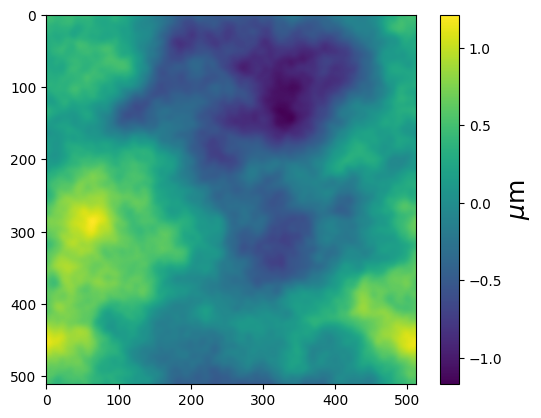

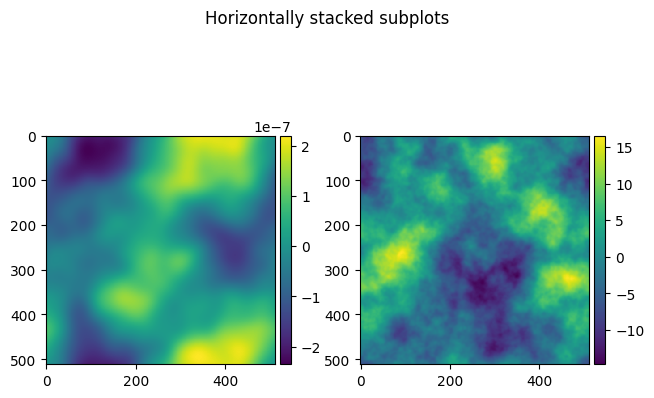

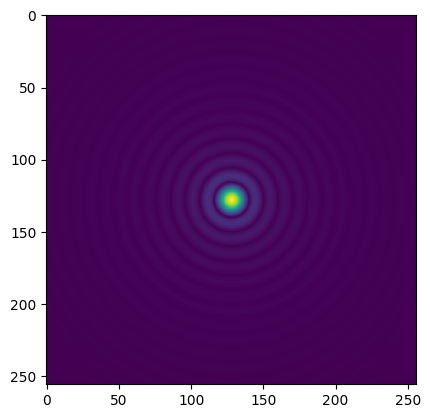

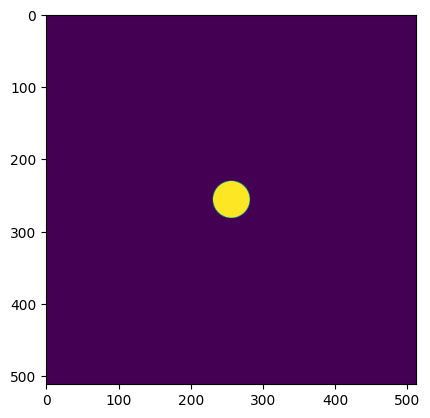

In [13]:
%matplotlib inline
plt.figure()
plt.imshow(pupil)

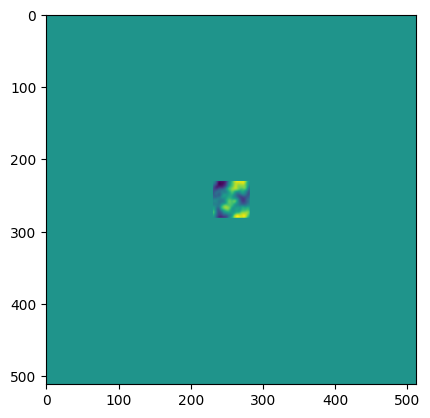

In [14]:
plt.figure()
plt.imshow(nfphase1)

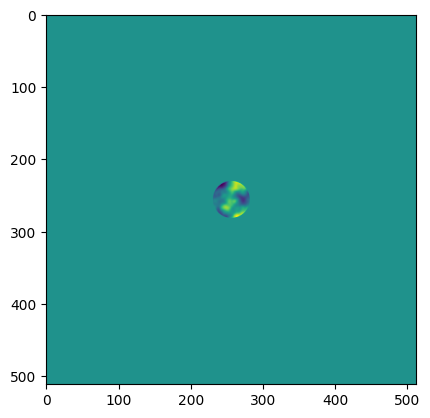

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.imshow(pupil*nfphase1)